Aim
---

To build a spatio-temporal simulator that can predict the spread of
Covid-19 in Kerala under different mitigation strategies. We hope that
this will be useful for experts in community health to corroborate their
intuition against a mathematical prediction.

Key features
------------

1.  The resolution of the model is at the smallest local self-governing
    division (LSGD) in Kerala. That is, grama panchayat, municipality or
    municipal corporation.

2.  The predictions are based on available information about the
    characteristics of the disease, the geographic and demographic data
    of Kerala and the statistics of reported cases so far.

3.  The time evolution of the disease in each LSGD is modelled using a
    deterministic [SEIR
    model](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SEIR_model)
    fine-tuned for Covid-19.

4.  The mixing of population between panchayats is based on the
    [*radiation law* for human
    mobility](https://en.wikipedia.org/wiki/Radiation_law_for_human_mobility)

5.  Spatio-temporal effect of various lockdown strategies can be tried
    out by the user. Some examples of lockdown strategies include

    1.  Lockdown a panchayat for $d$ days if there are more than $c$
        active cases in that panchayat.  
    2.  Lockdown a panchayat and its neighbouring panchayats for $d$
        days if there are more than $c$ active cases in that panchayat.

6.  A lockdown strategy will be declared as *safe* if the demand for
    number of cases needing hospitalisation is within the capacity of
    the corresponding LSGD at every point in time. Other strategies will
    be declared as *unsafe*. A quality parameter will be reported for
    each safe strategy tried. The quality parameter is equal to the
    average number of working days (non-lockdown days) per person for
    the next year.

7.  The system will automatically try out various lockdown strategies in
    the backend and provide a small set of safe strategies which acheive
    high values for the above quality parameter.

User interface
--------------

1.  A web dashboard like
    [Covid19-Scenarios](https://covid19-scenarios.org/) with added
    map-based animations like
    [OurWoldInData](https://ourworldindata.org/grapher/total-covid-deaths-per-million)
    for projected data.

2.  The user can try out the effect of various spatio-temporal lockdown
    strategies like those available in
    [CovidMeasures](https://covid-measures.github.io/)

3.  A discussion forum (not sure if it is needed or not)

4.  A logging of crowd-sourced high quality strategies (again, not sure)

Time evolution (SEIHR Model) - Biren might update this
------------------------------------------------------

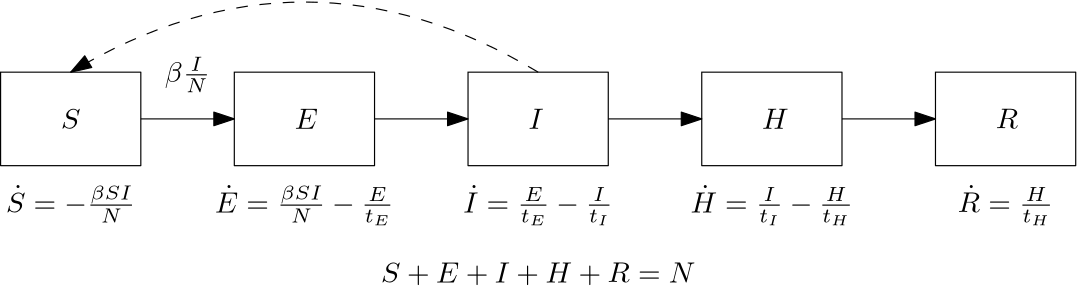

The SEIHR model considers the total population $N_i$ in a region $R_i$
as being split into five compartments based on their stage of infection.
The number of people in these five compartments is a function of time
but they always add to $N_i$.

-   $S$ : Susceptible (before virus enters their body)
-   $E$ : Exposed (virus is multiplying inside their body but they are
    not infectious/contagious yet)
-   $I$ : Infectious
-   $H$ : Not infectious but still hospitalised
-   $R$ : Removed (recovered + dead)

The reason to add a separate category H to the standard SEIR model is to
estimate the load on hospital beds. The number of hospital beds will be
a function of I + H and not I alone.

### Update equations

If we discretize time $t$ to represent days, then we can write the
update equations as

$$\begin{aligned}
\dot S_i     &= -\beta S_i \frac{I_i}{N_i} \\
\dot E_i     &= \beta S_i \frac{I_i}{N_i} - \frac{E_i}{t_E}\\
\dot I_i     &= \frac{E_i}{t_E} - \frac{I_i}{t_I}\\
\dot H_i     &= \frac{I_i}{t_I} - \frac{H_i}{t_H}\\
\dot R_i     &= \frac{H_i}{t_H}\\
\end{aligned}$$

Here

-   $\beta = \pi c$, where
    -   $\pi$ is the probability that a susceptible person who contacts
        an infectious person catches the disease (not all contacts
        transmit the disease)

    -   $c$ is the expected number of people that a susceptible person
        contacts in a day. Going further we will have to model it as
        $c = c_h + c_w$, where $c_h$ and $c_w$ are the expected number
        of people that a susceptible person contacts at home and
        work/school respectively.

    -   $c \frac{I_i}{N_i}$ therefore, is the expected number of
        infectious people that a susceptible person contacts in a day.

    -   $\pi c \frac{I_i}{N_i}$ therefore, is the probability that that
        a susceptible person catches the disease in a day.
-   $t_E$, $t_I$ and $t_R$ are the mean time that a person spends in the
    respective compartments, before moving onto the next.

### Current parameter choices

-   $\pi \approx 0.02$, this can reduce with the use of masks and
    regular cleansing.
-   $c_h \approx 5$
-   $c_w$ is typically 15 on a normal day and 0 on a lockdown day.
-   $t_E \approx 5$
-   $t_I \approx 5$
-   $t_H \approx 9$

Spatial mixing (Radiation Model)
--------------------------------

1.  We say that a person *travels* from region $R_1$ to region $R_2$, if
    she lives in $R_1$ but works mostly in $R_2$. We will assume that
    there are $r$ regions in total.

2.  **Radiation model.** The number of people $T_{i,j}$ travelling from
    region $R_i$ to region $R_j$ on a working day is modelled as

    $$
    T_{i,j} = T_i \frac {N_i N_j}{(N_i + S_{i,j})(N_i + N_j + S_{i,j})},
    $$ where

    -   $N_i$ is the population of $R_i$

    -   $N_j$ is the population of $R_j$

    -   $T_i$ is the total number of people who travel out for work from
        region $R_i$. At a larger granularity this data for each region
        may be available from Census. Otherwise, one can model it as
        $T_i = \mu N_i$, pick $\mu$ from the census data. The proportion
        of people who travel more than 5 km for work may be a good proxy
        for $\mu$ at LSGD level (need to discuss this).

    -   $S_{i,j}$ is the total population in all the regions (except
        $R_i$ itself) which are closer to $R_i$ than $R_j$. That is,

        $$
        S_{i,j} = \sum_{k=1}^{r} \{N_k :~ 0 < d(R_k, R_i) < d(R_j, R_i)\}.
        $$

        It turns out that $T_i = \sum T_{i,j}$. We will also set
        $T_{i,i} = N_i - T_i$, which can be interpretted as the number
        of people from region $R_i$ travelling to $R_i$ itself. This
        will make the future summations easier to write.

3.  **Workplace Contact Matrix.** This is an $r \times r$ matrix $C_w$
    in which the entry $C_w[i,j]$ is the expected number of people from
    region $R_j$ that a susceptible person from region $R_i$ will
    contact at workplace/school in a day. We model it as

    $$
    C_w[i,j] = c_w \sum_{i=1}^{r} \frac{T_{i,k}}{N_i} 
            \frac{T_{j,k}}{\sum_{l=1}^{r} T_{l,k}}
    $$

    If you consider a person picked uniformly at random from region
    $R_i$, the term $\frac{T_{i,k}}{N_i}$ can be interpretted as the
    probability that she goes for work in region $R_k$ and the term
    $\frac{T_{j,k}}{\sum_{l=1}^{r} T_{l,k}}$ can be interpretted as th
    probability that a person she contacts at workplace (in region
    $R_k$) has come to work there from region $R_j$. Notice that the
    total number of people in region $R_k$ during the day is not $N_k$
    but $\sum_{l=1}^{r} T_{l,k}$. Since we have chosen $T_{k,k}$ as
    $N_k - T_k$, this sum will account for the people leaving and
    entering $R_k$ for work.

4.  **Contact Matrix.** The contact matrix $C$ is obtained by adding
    $c_h$ to each diagonal entry of $C_w$. This is justified since all
    household contacts happen in the region of a person’s living.

### Current parameter choices

-   $\mu \approx 0.01$ (will update after looking at census data)

Spatio-Temporal Evolution
-------------------------

The following equations are adapted from Eqn (4), Section 3.1.2 in a
[2016 paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5348083/).
This seems to miss the travel out of region $R_i$. $$
\begin{aligned}
    \dot S_i &=     - \pi S_i \sum_{j=1}^{n} C_{i,j} \frac{I_j}{N_j} \\
    \dot E_i &=       \pi S_i \sum_{j=1}^{n} C_{i,j}\frac{I_j}{N_j}
                    - \frac{E_i}{t_E} \\
    \dot I_i &=   \frac{E_i}{t_E} 
                    - \frac{I_i}{t_I} 
                    + \sum_j \theta_{j,i}I_j \\
    \dot R_i &=     \frac{I_i}{t_I} 
                    + \sum_j \theta_{j,i}R_j
\end{aligned}
$$

The sum $\sum_{j=1}^{n} C_{i,j} \frac{I_j}{N_j}$ can be implemented as a
matrix-vector multiplication if that will speed up the code.

Modelling Mitigation strategies
-------------------------------

1.  Every lockdown strategy is a control on the matrix $C_w$. Lockdown
    in a region $R_i$ can be modelled by zeroing out the $i$-th row and
    column of $C_w$ or by scaling it down by a fraction like $0.1$ to
    allow for the essential services. A time dependent lockdown strategy
    will do this tweaking with the $C_w$ matrix differently at different
    time-steps.

2.  Break-the-chain campaigns like masks, hand sanitizers, social
    distancing etc are a control on $\pi$.

3.  Effect of contact tracing and quarantining suspected contacts is
    difficult to be modelled in our setup.

4.  To model the effect of isolating symptomatic patients, we will need
    to split the compartment $I$.

Justifying the model and parameter choices
------------------------------------------

Team
----

-   Arun Ramachandran
-   Birenjith P. S.
-   Deepak R.
-   Sajith V. K.
-   Sreeram H.